In [8]:
"""
Processing the data
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'VFlow'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [2]:
def train_model(model, X_train, y_train, name, scats_number, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05,
        verbose=0)

    #Create folder structure: model/<model_name>/<scats_number>
    model_folder = f'model/{name}/{scats_number}'
    os.makedirs(model_folder, exist_ok=True)

    #Save the model and loss history
    model.save(f'{model_folder}/{name}_{scats_number}.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv(f'{model_folder}/{name}_{scats_number}_loss.csv', encoding='utf-8', index=False)

In [3]:
import os
import numpy as np

def do_train(model_name):
    lag = 12
    config = {"batch": 256, "epochs": 500}

    train_folder = 'intersection/train/'
    test_folder = 'intersection/test/'

    for filename in os.listdir(train_folder):
        if filename.endswith(".csv"):
            scats_number = filename.split('_')[1].split('.')[0]
            train_file = os.path.join(train_folder, filename)
            test_file = os.path.join(test_folder, f"test_{scats_number}.csv")

            print(f"Processing SCATS Number: {scats_number}")

            # Assuming process_data function returns data in the right format
            X_train, y_train, X_test, y_test, scaler = process_data(train_file, test_file, lag)

            model_file_name = model_name

            if model_name == 'lstm':
                X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
                m = get_lstm([12, 64, 64, 1])
                train_model(m, X_train, y_train, model_file_name, scats_number, config)

            elif model_name == 'gru':
                X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
                m = get_gru([12, 64, 64, 1])
                train_model(m, X_train, y_train, model_file_name, scats_number, config)

            elif model_name == 'sae':
                X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
                m = get_sae([12, 6, 3, 6, 12, 1])
                train_model(m, X_train, y_train, model_file_name, scats_number, config)

            elif model_name == 'nt_saes':
                X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
                m = get_nt_saes([12, 400, 400, 400, 1])
                train_nt_saes(m, X_train, y_train, model_file_name, scats_number, config)
                
            elif model_name == 'cnn':
                X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # reshape for 1D CNN
                m = get_cnn((lag, 1))
                train_model(m, X_train, y_train, model_file_name, scats_number, config)

            print(f"Saved model for SCATS Number: {scats_number}")

In [4]:
"""
Defination of NN model
"""
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input, LSTM, GRU, Dense 
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Input(shape=(units[0], 1)))
    model.add(LSTM(units[1], return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_sae(layers):    
    sae = Sequential()
    sae.add(Input([layers[0]]))
    sae.add(Dense(layers[0], activation='selu', name='encoder_1'))
    sae.add(Dense(layers[1], activation='selu', name='encoder_2'))
    sae.add(Dense(layers[2], activation='selu', name='hidden_bottleneck'))
    sae.add(Dense(layers[3], activation='selu', name='decoder_2'))
    sae.add(Dense(layers[4], activation='selu', name='decoder_1'))
    sae.add(Dense(layers[5], activation='sigmoid', name='output'))
    
    return sae


def _get_nt_sae(inputs, hidden, output):
    """SAE(Auto-Encoders)
    Build SAE Model.

    # Arguments
        inputs: Integer, number of input units.
        hidden: Integer, number of hidden units.
        output: Integer, number of output units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

    return model


def get_nt_saes(layers):
    """SAEs(Stacked Auto-Encoders)
    Build SAEs Model.

    # Arguments
        layers: List(int), number of input, output and hidden units.
    # Returns
        models: List(Model), List of SAE and SAEs.
    """
    sae1 = _get_nt_sae(layers[0], layers[1], layers[-1])
    sae2 = _get_nt_sae(layers[1], layers[2], layers[-1])
    sae3 = _get_nt_sae(layers[2], layers[3], layers[-1])

    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[2], name='hidden2'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[3], name='hidden3'))
    saes.add(Activation('sigmoid'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [sae1, sae2, sae3, saes]

    return models

# Define the CNN model function
def get_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
def train_nt_saes(models, X_train, y_train, name, scats_number, config):
    """train
    train the SAEs model.

    # Arguments
        models: List, list of SAE model.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    temp = X_train
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')

    for i in range(len(models) - 1):
        if i > 0:
            p = models[i - 1]
            hidden_layer_model = Model(inputs=p.inputs,
                                       outputs=p.get_layer('hidden').output)
            temp = hidden_layer_model.predict(temp)

        m = models[i]
        m.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])

        m.fit(temp, y_train, batch_size=config["batch"],
              epochs=config["epochs"],
              validation_split=0.05)

        models[i] = m

    saes = models[-1]
    for i in range(len(models) - 1):
        weights = models[i].get_layer('hidden').get_weights()
        saes.get_layer('hidden%d' % (i + 1)).set_weights(weights)

    train_model(saes, X_train, y_train, name, scats_number, config)

## warning: this stuff will take ages to run and needs GPU time

In [6]:
from keras.models import Model
from keras.callbacks import EarlyStopping

In [6]:
do_train('sae')

Processing SCATS Number: 3662


I0000 00:00:1729804772.421417   26646 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-25 08:19:32.446653: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Saved model for SCATS Number: 3662
Processing SCATS Number: 2820


Saved model for SCATS Number: 2820
Processing SCATS Number: 4034


Saved model for SCATS Number: 4034
Processing SCATS Number: 4040


Saved model for SCATS Number: 4040
Processing SCATS Number: 4335


Saved model for SCATS Number: 4335
Processing SCATS Number: 4266


Saved model for SCATS Number: 4266
Processing SCATS Number: 4264


Saved model for SCATS Number: 4264
Processing SCATS Number: 2827


Saved model for SCATS Number: 2827
Processing SCATS Number: 4263


Saved model for SCATS Number: 4263
Processing SCATS Number: 3127


Saved model for SCATS Number: 3127
Processing SCATS Number: 4057


Saved model for SCATS Number: 4057
Processing SCATS Number: 2000


Saved model for SCATS Number: 2000
Processing SCATS Number: 4035


Saved model for SCATS Number: 4035
Processing SCATS Number: 4032


Saved model for SCATS Number: 4032
Processing SCATS Number: 3120


Saved model for SCATS Number: 3120
Processing SCATS Number: 4270


Saved model for SCATS Number: 4270
Processing SCATS Number: 3682


Saved model for SCATS Number: 3682
Processing SCATS Number: 3812


Saved model for SCATS Number: 3812
Processing SCATS Number: 2846


Saved model for SCATS Number: 2846
Processing SCATS Number: 2825


Saved model for SCATS Number: 2825
Processing SCATS Number: 3122


Saved model for SCATS Number: 3122
Processing SCATS Number: 3180


Saved model for SCATS Number: 3180
Processing SCATS Number: 3126


Saved model for SCATS Number: 3126
Processing SCATS Number: 4321


Saved model for SCATS Number: 4321
Processing SCATS Number: 970


Saved model for SCATS Number: 970
Processing SCATS Number: 4043


Saved model for SCATS Number: 4043
Processing SCATS Number: 4262


Saved model for SCATS Number: 4262
Processing SCATS Number: 4272


Saved model for SCATS Number: 4272
Processing SCATS Number: 4812


Saved model for SCATS Number: 4812
Processing SCATS Number: 4821


Saved model for SCATS Number: 4821
Processing SCATS Number: 4051


Saved model for SCATS Number: 4051
Processing SCATS Number: 3804


Saved model for SCATS Number: 3804
Processing SCATS Number: 3002


Saved model for SCATS Number: 3002
Processing SCATS Number: 4030


Saved model for SCATS Number: 4030
Processing SCATS Number: 2200


Saved model for SCATS Number: 2200
Processing SCATS Number: 4063


Saved model for SCATS Number: 4063
Processing SCATS Number: 4273


Saved model for SCATS Number: 4273
Processing SCATS Number: 3001


Saved model for SCATS Number: 3001
Processing SCATS Number: 3685


Saved model for SCATS Number: 3685
Processing SCATS Number: 4324


Saved model for SCATS Number: 4324


In [ ]:
do_train('nt_saes')

START NEXT TRAIN FROM HERE!!!!!!!!!!!!!!!!

In [ ]:
do_train('gru')

In [ ]:
do_train('lstm')

In [ ]:
do_train('cnn')

Processing SCATS Number: 2000


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2000
Processing SCATS Number: 2200


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2200
Processing SCATS Number: 2820


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2820
Processing SCATS Number: 2825


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2825
Processing SCATS Number: 2827


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2827
Processing SCATS Number: 2846


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 2846
Processing SCATS Number: 3001


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3001
Processing SCATS Number: 3002


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3002
Processing SCATS Number: 3120


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3120
Processing SCATS Number: 3122


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3122
Processing SCATS Number: 3126


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3126
Processing SCATS Number: 3127


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3127
Processing SCATS Number: 3180


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3180
Processing SCATS Number: 3662


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3662
Processing SCATS Number: 3682


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3682
Processing SCATS Number: 3685


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3685
Processing SCATS Number: 3804


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3804
Processing SCATS Number: 3812


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 3812
Processing SCATS Number: 4030


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4030
Processing SCATS Number: 4032


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4032
Processing SCATS Number: 4034


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4034
Processing SCATS Number: 4035


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4035
Processing SCATS Number: 4040


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4040
Processing SCATS Number: 4043


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4043
Processing SCATS Number: 4051


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4051
Processing SCATS Number: 4057


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4057
Processing SCATS Number: 4063


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4063
Processing SCATS Number: 4262


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4262
Processing SCATS Number: 4263


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4263
Processing SCATS Number: 4264


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4264
Processing SCATS Number: 4266


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4266
Processing SCATS Number: 4270


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4270
Processing SCATS Number: 4272


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4272
Processing SCATS Number: 4273


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4273
Processing SCATS Number: 4321


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4321
Processing SCATS Number: 4324


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4324
Processing SCATS Number: 4335


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4335
Processing SCATS Number: 4812


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4812
Processing SCATS Number: 4821


C:\Users\ruchi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saved model for SCATS Number: 4821
Processing SCATS Number: 970


Saved model for SCATS Number: 970


## end of warning

In [13]:
import math
import warnings
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from keras.src.legacy.saving import legacy_h5_format

In [21]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, true data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred, silent=False):
    """Evaluation
    evaluate the predicted result.

    # Arguments
        y_true: List/ndarray, true data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    if not silent:
        print('explained_variance_score:%f' % vs)
        print('mape:%f%%' % mape)
        print('mae:%f' % mae)
        print('mse:%f' % mse)
        print('rmse:%f' % math.sqrt(mse))
        print('r2:%f' % r2)
        
    return mape, vs, mae, mse, r2

def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, true data.
        y_preds: List of ndarrays, predicted data for each model.
        names: List, Method names.
    """
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=96, freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()


def main():
    lag = 12
    train_folder = 'intersection/train/'
    test_folder = 'intersection/test/'

    models = ['lstm', 'gru', 'sae', 'nt_saes', 'cnn']
    names = ['LSTM', 'GRU', 'SAE', 'NT_SAEs', 'CNN']

    stats_row_list = []
    
    for filename in os.listdir(train_folder):
        if filename.endswith(".csv"):
            scats_number = filename.split('_')[1].split('.')[0]
            train_file = os.path.join(train_folder, filename)
            test_file = os.path.join(test_folder, f"test_{scats_number}.csv")

            print(f"Evaluating for SCATS Number: {scats_number}")
            _, _, X_test, y_test, scaler = process_data(train_file, test_file, lag)
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

            y_preds = []

            models_to_remove = []
            for model_variant in models:
                
                try:
                    model = load_model(f"model/{model_variant}/{scats_number}/{model_variant}_{scats_number}.h5", custom_objects={'mse': 'mse'})
                except:
                    print(f'No model found for {model_variant} in {scats_number}... assuming not trained, removing from models to test.')
                    models_to_remove.append(model_variant)
                    continue
                
                if model_variant == 'cnn':
                    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # CNN-specific reshaping
                else:
                    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
                
                predicted = model.predict(X_test_reshaped)
                predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
                y_preds.append(predicted[:96])
    
                print(f"Evaluating {model_variant} for SCATS Number: {scats_number}")
                mape, vs, mae, mse, r2 = eva_regress(y_test, predicted, silent=False)
    
                model_stats = {
                    'scats': scats_number,
                    'model': model_variant,
                    'mape': mape,
                    'vs': vs,
                    'mae': mae,
                    'mse': mse,
                    'r2': r2
                }
    
                stats_row_list.append(model_stats)

            for model_variant in models_to_remove:
                models.remove(model_variant)

    stats_df = pd.DataFrame(stats_row_list)
    stats_df.set_index('scats')

    stats_df.to_csv('intersections_test_results.csv')
    plot_results(y_test[:96], y_preds, names)


Evaluating for SCATS Number: 2000
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating lstm for SCATS Number: 2000
explained_variance_score:0.947053
mape:18.671098%
mae:17.476187
mse:593.427333
rmse:24.360364
r2:0.942853


103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating gru for SCATS Number: 2000


explained_variance_score:0.947260
mape:17.912293%
mae:16.684782
mse:551.212972
rmse:23.477925
r2:0.946918
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


Evaluating sae for SCATS Number: 2000
explained_variance_score:0.942774
mape:15.270475%
mae:17.439117
mse:628.927454
rmse:25.078426
r2:0.939434
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 2000
explained_variance_score:0.944355
mape:17.523863%
mae:17.158273
mse:580.540555
rmse:24.094409
r2:0.944094
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


Evaluating cnn for SCATS Number: 2000
explained_variance_score:0.942885
mape:16.331951%
mae:16.975284
mse:594.027382
rmse:24.372677
r2:0.942795
Evaluating for SCATS Number: 2200
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating lstm for SCATS Number: 2200


explained_variance_score:0.931651
mape:25.039807%
mae:11.845026
mse:292.578402
rmse:17.104923
r2:0.929267
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating gru for SCATS Number: 2200


explained_variance_score:0.936682
mape:25.948878%
mae:11.373609
mse:261.924992
rmse:16.184097
r2:0.936678
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step


Evaluating sae for SCATS Number: 2200
explained_variance_score:0.929942
mape:28.107631%
mae:12.234899
mse:313.022909
rmse:17.692453
r2:0.924325
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step


Evaluating nt_saes for SCATS Number: 2200
explained_variance_score:0.932433
mape:30.856653%
mae:11.832196
mse:280.567243
rmse:16.750142
r2:0.932171
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


Evaluating cnn for SCATS Number: 2200
explained_variance_score:0.933760
mape:22.116578%
mae:11.445084
mse:275.501952
rmse:16.598251
r2:0.933396
Evaluating for SCATS Number: 2820
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating lstm for SCATS Number: 2820


explained_variance_score:0.955724
mape:22.566440%
mae:16.927385
mse:550.468390
rmse:23.462063
r2:0.955081
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Evaluating gru for SCATS Number: 2820
explained_variance_score:0.957390
mape:27.846322%
mae:16.633519
mse:522.184109
rmse:22.851348
r2:0.957389
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 2820
explained_variance_score:0.964810
mape:19.602286%
mae:14.762467
mse:441.214563
rmse:21.005108
r2:0.963996
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating nt_saes for SCATS Number: 2820
explained_variance_score:0.949095
mape:23.489819%
mae:20.270182
mse:764.772890
rmse:27.654527
r2:0.937594


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 2820
explained_variance_score:0.962521
mape:22.270679%
mae:15.556723
mse:472.758643
rmse:21.743014
r2:0.961422
Evaluating for SCATS Number: 2825
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating lstm for SCATS Number: 2825
explained_variance_score:0.953998
mape:34.824717%
mae:17.134350
mse:514.629547
rmse:22.685448
r2:0.953781


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Evaluating gru for SCATS Number: 2825
explained_variance_score:0.952409
mape:40.390045%
mae:17.842580
mse:530.526736
rmse:23.033166
r2:0.952353
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Evaluating sae for SCATS Number: 2825
explained_variance_score:0.961286
mape:33.401114%
mae:17.756894
mse:552.080530
rmse:23.496394
r2:0.950417
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Evaluating nt_saes for SCATS Number: 2825
explained_variance_score:0.941148
mape:34.325948%
mae:18.918316
mse:659.713525
rmse:25.684889
r2:0.940751
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluating cnn for SCATS Number: 2825
explained_variance_score:0.966592
mape:16.045191%
mae:14.252731
mse:396.375578
rmse:19.909183
r2:0.964401
Evaluating for SCATS Number: 2827


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 2827
explained_variance_score:0.947397
mape:28.292580%
mae:13.862927
mse:382.773267
rmse:19.564592
r2:0.947396
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 2827
explained_variance_score:0.949043
mape:26.771153%
mae:13.683866
mse:377.061617
rmse:19.418074
r2:0.948181
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 2827
explained_variance_score:0.941415
mape:26.816420%
mae:15.475679
mse:505.113141
rmse:22.474722
r2:0.930584
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 2827
explained_variance_score:0.951019
mape:35.124757%
mae:14.098674
mse:373.073377
rmse:19.315107
r2:0.948729
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Evaluating cnn for SCATS Number: 2827
explained_variance_score:0.943688
mape:26.136141%
mae:14.325074
mse:411.333413
rmse:20.281356
r2:0.943471
Evaluating for SCATS Number: 2846


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 2846
explained_variance_score:0.960837
mape:171.341576%
mae:8.041753
mse:110.434683
rmse:10.508791
r2:0.948247
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 2846
explained_variance_score:0.963285
mape:122.610968%
mae:6.643494
mse:89.524442
rmse:9.461736
r2:0.958046
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 2846
explained_variance_score:0.964045
mape:116.144365%
mae:6.289426
mse:83.783956
rmse:9.153358
r2:0.960737
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 2846
explained_variance_score:0.962993
mape:158.423987%
mae:7.382797
mse:97.605342
rmse:9.879542
r2:0.954260


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 2846
explained_variance_score:0.965406
mape:141.913970%
mae:7.375394
mse:99.228486
rmse:9.961350
r2:0.953499
Evaluating for SCATS Number: 3001


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating lstm for SCATS Number: 3001


explained_variance_score:0.729732
mape:30.764821%
mae:44.834518
mse:4032.036451
rmse:63.498318
r2:0.699510
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3001
explained_variance_score:0.738124
mape:31.708797%
mae:43.277325
mse:3645.944889
rmse:60.381660
r2:0.728284
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating sae for SCATS Number: 3001
explained_variance_score:0.716772
mape:32.028807%
mae:45.029342
mse:4043.957231
rmse:63.592116
r2:0.698622
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating nt_saes for SCATS Number: 3001


explained_variance_score:0.736197
mape:28.734163%
mae:45.371501
mse:4263.783156
rmse:65.297650
r2:0.682239
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 3001
explained_variance_score:0.723879
mape:32.442571%
mae:45.274122
mse:4038.886966
rmse:63.552238
r2:0.699000
Evaluating for SCATS Number: 3002
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating lstm for SCATS Number: 3002
explained_variance_score:0.922074
mape:24.111296%
mae:15.044600
mse:474.688791
rmse:21.787354
r2:0.922047
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3002
explained_variance_score:0.922425
mape:25.217999%
mae:15.075404
mse:479.143907
rmse:21.889356
r2:0.921316
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


Evaluating sae for SCATS Number: 3002
explained_variance_score:0.922665
mape:27.453620%
mae:15.432046
mse:494.963568
rmse:22.247777
r2:0.918718
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 3002
explained_variance_score:0.919767
mape:27.384655%
mae:15.230992
mse:488.581117
rmse:22.103871
r2:0.919766
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 3002
explained_variance_score:0.921937
mape:19.582982%
mae:15.346183
mse:495.090382
rmse:22.250627
r2:0.918697
Evaluating for SCATS Number: 3120
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating lstm for SCATS Number: 3120


explained_variance_score:0.875372
mape:11.257162%
mae:12.565315
mse:256.818971
rmse:16.025572
r2:0.849839
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3120
explained_variance_score:0.879298
mape:9.691919%
mae:10.793319
mse:211.199154
rmse:14.532693
r2:0.876513
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3120
explained_variance_score:0.880279
mape:10.843651%
mae:12.354084
mse:254.911342
rmse:15.965943
r2:0.850955
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 3120
explained_variance_score:0.886333
mape:11.277365%
mae:11.853683
mse:237.311314
rmse:15.404912
r2:0.861245
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 3120
explained_variance_score:0.879659
mape:9.231411%
mae:10.609160
mse:217.692628
rmse:14.754410
r2:0.872716
Evaluating for SCATS Number: 3122
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating lstm for SCATS Number: 3122


explained_variance_score:0.947950
mape:37.443160%
mae:15.163648
mse:431.538018
rmse:20.773493
r2:0.942002
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3122
explained_variance_score:0.959531
mape:34.173633%
mae:13.016036
mse:307.021839
rmse:17.522039
r2:0.958737
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3122
explained_variance_score:0.957119
mape:29.208246%
mae:13.968604
mse:377.817365
rmse:19.437525
r2:0.949222
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 3122
explained_variance_score:0.952428
mape:42.757200%
mae:15.368074
mse:427.602079
rmse:20.678542
r2:0.942531
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 3122
explained_variance_score:0.959432
mape:23.111790%
mae:12.682119
mse:313.638778
rmse:17.709850
r2:0.957847
Evaluating for SCATS Number: 3126
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3126
explained_variance_score:0.913985
mape:18.422062%
mae:24.972694
mse:1366.362925
rmse:36.964347
r2:0.902580
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3126
explained_variance_score:0.913122
mape:22.125883%
mae:25.537240
mse:1281.255860
rmse:35.794635
r2:0.908648
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step


Evaluating sae for SCATS Number: 3126
explained_variance_score:0.916307
mape:18.636944%
mae:23.280553
mse:1186.698417
rmse:34.448489
r2:0.915389
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 3126
explained_variance_score:0.917133
mape:21.143370%
mae:23.784569
mse:1205.745656
rmse:34.723849
r2:0.914031
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 3126
explained_variance_score:0.924316
mape:20.654030%
mae:24.961731
mse:1294.844361
rmse:35.983946
r2:0.907679
Evaluating for SCATS Number: 3127
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Evaluating lstm for SCATS Number: 3127
explained_variance_score:0.948191
mape:22.674955%
mae:17.937478
mse:665.598661
rmse:25.799199
r2:0.946294
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 3127
explained_variance_score:0.957826
mape:27.505303%
mae:16.215274
mse:523.073592
rmse:22.870802
r2:0.957794
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3127
explained_variance_score:0.951072
mape:27.389177%
mae:17.440904
mse:617.751147
rmse:24.854600
r2:0.950155
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 3127
explained_variance_score:0.954154
mape:30.825660%
mae:18.399144
mse:664.299276
rmse:25.774004
r2:0.946399
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 3127
explained_variance_score:0.949941
mape:22.919111%
mae:17.504341
mse:620.898778
rmse:24.917841
r2:0.949901
Evaluating for SCATS Number: 3180
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3180
explained_variance_score:0.887496
mape:37.912398%
mae:12.269383
mse:280.432166
rmse:16.746109
r2:0.887324
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 3180
explained_variance_score:0.890235
mape:45.061510%
mae:12.250676
mse:282.386367
rmse:16.804356
r2:0.886539
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3180
explained_variance_score:0.897031
mape:33.812173%
mae:11.697127
mse:261.275276
rmse:16.164012
r2:0.895021
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 3180
explained_variance_score:0.885025
mape:46.594212%
mae:13.008757
mse:323.061048
rmse:17.973899
r2:0.870196
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 3180
explained_variance_score:0.885415
mape:38.425418%
mae:12.235131
mse:290.119802
rmse:17.032904
r2:0.883431
Evaluating for SCATS Number: 3662
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3662
explained_variance_score:0.902665
mape:46.097781%
mae:13.764574
mse:390.899890
rmse:19.771188
r2:0.901849
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3662
explained_variance_score:0.889938
mape:52.881266%
mae:14.616302
mse:440.899636
rmse:20.997610
r2:0.889295
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3662
explained_variance_score:0.895507
mape:42.966871%
mae:13.943993
mse:416.529166
rmse:20.409046
r2:0.895414
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 3662
explained_variance_score:0.894475
mape:58.494269%
mae:15.407299
mse:475.198930
rmse:21.799058
r2:0.880682
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 3662
explained_variance_score:0.900958
mape:28.354651%
mae:13.224654
mse:396.972951
rmse:19.924180
r2:0.900324
Evaluating for SCATS Number: 3682
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3682
explained_variance_score:0.938672
mape:25.618621%
mae:13.064279
mse:377.914415
rmse:19.440021
r2:0.938189
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3682
explained_variance_score:0.942242
mape:28.809277%
mae:12.881120
mse:358.460226
rmse:18.933046
r2:0.941371
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3682
explained_variance_score:0.941374
mape:28.937385%
mae:13.198636
mse:378.046982
rmse:19.443430
r2:0.938168
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 3682
explained_variance_score:0.939526
mape:34.162008%
mae:13.302574
mse:371.822300
rmse:19.282694
r2:0.939186
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 3682
explained_variance_score:0.930917
mape:32.865208%
mae:14.152298
mse:437.790738
rmse:20.923449
r2:0.928396
Evaluating for SCATS Number: 3685
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Evaluating lstm for SCATS Number: 3685
explained_variance_score:0.902782
mape:20.988982%
mae:40.571114
mse:4008.484817
rmse:63.312596
r2:0.873446
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3685
explained_variance_score:0.902978
mape:23.610910%
mae:39.991050
mse:3937.451768
rmse:62.749118
r2:0.875688
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


Evaluating sae for SCATS Number: 3685
explained_variance_score:0.902332
mape:24.820057%
mae:41.517546
mse:4126.643482
rmse:64.238956
r2:0.869715
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 3685
explained_variance_score:0.910413
mape:25.140540%
mae:41.644345
mse:4038.096360
rmse:63.546018
r2:0.872511
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 3685
explained_variance_score:0.933503
mape:24.814691%
mae:33.529994
mse:2440.735904
rmse:49.403805
r2:0.922942
Evaluating for SCATS Number: 3804
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3804
explained_variance_score:0.895574
mape:31.372405%
mae:17.766336
mse:618.062178
rmse:24.860856
r2:0.895371
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Evaluating gru for SCATS Number: 3804
explained_variance_score:0.894053
mape:29.370788%
mae:17.931221
mse:627.844503
rmse:25.056825
r2:0.893715
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


Evaluating sae for SCATS Number: 3804
explained_variance_score:0.894575
mape:33.128487%
mae:18.444393
mse:660.935445
rmse:25.708665
r2:0.888113
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 3804
explained_variance_score:0.888533
mape:32.498187%
mae:18.648089
mse:691.139749
rmse:26.289537
r2:0.883000
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 3804
explained_variance_score:0.893894
mape:32.356545%
mae:17.871940
mse:635.269949
rmse:25.204562
r2:0.892458
Evaluating for SCATS Number: 3812


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 3812
explained_variance_score:0.778652
mape:44.769699%
mae:23.383219
mse:1193.322092
rmse:34.544494
r2:0.778573
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 3812
explained_variance_score:0.779340
mape:44.891804%
mae:23.029506
mse:1193.521335
rmse:34.547378
r2:0.778536
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 3812
explained_variance_score:0.782754
mape:44.805621%
mae:23.021921
mse:1171.731978
rmse:34.230571
r2:0.782579
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 3812
explained_variance_score:0.774948
mape:52.378204%
mae:23.919772
mse:1214.439109
rmse:34.848804
r2:0.774655


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step


Evaluating cnn for SCATS Number: 3812
explained_variance_score:0.788609
mape:49.183718%
mae:22.965700
mse:1141.093319
rmse:33.780073
r2:0.788265
Evaluating for SCATS Number: 4030
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4030
explained_variance_score:0.766885
mape:119.605667%
mae:6.091293
mse:58.038152
rmse:7.618277
r2:0.719998
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 4030
explained_variance_score:0.745861
mape:140.873610%
mae:6.328823
mse:57.046998
rmse:7.552946
r2:0.724780
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step


Evaluating sae for SCATS Number: 4030
explained_variance_score:0.780329
mape:131.662158%
mae:7.227796
mse:84.042071
rmse:9.167446
r2:0.594544
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 4030
explained_variance_score:0.798904
mape:238.499729%
mae:9.829337
mse:124.192942
rmse:11.144189
r2:0.400838
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating cnn for SCATS Number: 4030
explained_variance_score:0.722962
mape:98.870392%
mae:7.170031
mse:96.425447
rmse:9.819646
r2:0.534801
Evaluating for SCATS Number: 4032
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating lstm for SCATS Number: 4032
explained_variance_score:0.936367
mape:32.258648%
mae:12.018499
mse:279.541492
rmse:16.719494
r2:0.936364


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 4032
explained_variance_score:0.937128
mape:31.176603%
mae:11.949036
mse:276.380748
rmse:16.624703
r2:0.937084
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step


Evaluating sae for SCATS Number: 4032
explained_variance_score:0.939724
mape:33.695361%
mae:11.645814
mse:264.784324
rmse:16.272195
r2:0.939724
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating nt_saes for SCATS Number: 4032
explained_variance_score:0.934299
mape:45.373937%
mae:12.557742
mse:288.851716
rmse:16.995638
r2:0.934245
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 4032
explained_variance_score:0.940684
mape:27.025740%
mae:11.544460
mse:263.252912
rmse:16.225070
r2:0.940072
Evaluating for SCATS Number: 4034


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4034
explained_variance_score:0.940269
mape:32.465438%
mae:11.775847
mse:268.901252
rmse:16.398209
r2:0.940209
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 4034
explained_variance_score:0.943131
mape:39.807212%
mae:12.008035
mse:271.585411
rmse:16.479849
r2:0.939612
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 4034
explained_variance_score:0.938288
mape:37.359393%
mae:12.232019
mse:282.029445
rmse:16.793732
r2:0.937290
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 4034
explained_variance_score:0.938438
mape:42.030498%
mae:12.264951
mse:278.008413
rmse:16.673584
r2:0.938184
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating cnn for SCATS Number: 4034
explained_variance_score:0.937795
mape:36.299263%
mae:12.190115
mse:290.762608
rmse:17.051763
r2:0.935348
Evaluating for SCATS Number: 4035
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4035
explained_variance_score:0.933885
mape:29.144789%
mae:12.617778
mse:331.738278
rmse:18.213684
r2:0.933447
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 4035
explained_variance_score:0.937167
mape:33.977153%
mae:12.560880
mse:320.000202
rmse:17.888549
r2:0.935802
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating sae for SCATS Number: 4035
explained_variance_score:0.936993
mape:28.831001%
mae:12.433766
mse:314.287333
rmse:17.728151
r2:0.936948
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 4035


explained_variance_score:0.933169
mape:36.473381%
mae:12.902997
mse:333.306875
rmse:18.256694
r2:0.933133
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 4035
explained_variance_score:0.927958
mape:21.215423%
mae:13.003077
mse:360.421959
rmse:18.984782
r2:0.927693
Evaluating for SCATS Number: 4040
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4040
explained_variance_score:0.875846
mape:24.962364%
mae:10.953417
mse:229.134666
rmse:15.137195
r2:0.873525
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Evaluating gru for SCATS Number: 4040
explained_variance_score:0.877838
mape:27.054425%
mae:10.809831
mse:221.528965
rmse:14.883849
r2:0.877723
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


Evaluating sae for SCATS Number: 4040
explained_variance_score:0.876362
mape:26.662211%
mae:10.881580
mse:224.089782
rmse:14.969629
r2:0.876310
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating nt_saes for SCATS Number: 4040
explained_variance_score:0.876520
mape:25.904996%
mae:10.982948
mse:229.755291
rmse:15.157681
r2:0.873182


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 4040
explained_variance_score:0.875578
mape:25.240725%
mae:10.853166
mse:225.415513
rmse:15.013844
r2:0.875578
Evaluating for SCATS Number: 4043


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4043
explained_variance_score:0.935183
mape:18.177250%
mae:16.060130
mse:534.284677
rmse:23.114599
r2:0.934253
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 4043
explained_variance_score:0.937944
mape:19.646878%
mae:15.899545
mse:510.009355
rmse:22.583387
r2:0.937241
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 4043
explained_variance_score:0.933840
mape:18.767481%
mae:16.411306
mse:541.535569
rmse:23.270917
r2:0.933361
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 4043


explained_variance_score:0.939100
mape:20.615323%
mae:16.019173
mse:494.931229
rmse:22.247050
r2:0.939096
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating cnn for SCATS Number: 4043


explained_variance_score:0.917899
mape:17.415484%
mae:17.183027
mse:671.261040
rmse:25.908706
r2:0.917398
Evaluating for SCATS Number: 4051
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Evaluating lstm for SCATS Number: 4051
explained_variance_score:0.907090
mape:35.777143%
mae:8.843354
mse:144.211048
rmse:12.008790
r2:0.906879
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Evaluating gru for SCATS Number: 4051
explained_variance_score:0.906196
mape:36.880461%
mae:8.849385
mse:145.406409
rmse:12.058458
r2:0.906108
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 4051
explained_variance_score:0.910621
mape:25.849857%
mae:8.731046
mse:146.392443
rmse:12.099274
r2:0.905471
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluating nt_saes for SCATS Number: 4051


explained_variance_score:0.906769
mape:38.148119%
mae:9.559514
mse:169.326282
rmse:13.012543
r2:0.890662
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Evaluating cnn for SCATS Number: 4051
explained_variance_score:0.907778
mape:31.370170%
mae:8.723001
mse:144.727533
rmse:12.030276
r2:0.906546
Evaluating for SCATS Number: 4057


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Evaluating lstm for SCATS Number: 4057
explained_variance_score:0.924033
mape:35.253443%
mae:12.802545
mse:337.290118
rmse:18.365460
r2:0.917929


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Evaluating gru for SCATS Number: 4057
explained_variance_score:0.923821
mape:44.923377%
mae:12.929835
mse:343.766751
rmse:18.540948
r2:0.916353


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Evaluating sae for SCATS Number: 4057
explained_variance_score:0.919570
mape:35.045317%
mae:12.231354
mse:330.915567
rmse:18.191085
r2:0.919480


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Evaluating nt_saes for SCATS Number: 4057
explained_variance_score:0.923473
mape:38.019022%
mae:12.109620
mse:316.721476
rmse:17.796670
r2:0.922934


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Evaluating cnn for SCATS Number: 4057
explained_variance_score:0.924124
mape:43.312436%
mae:12.364078
mse:316.991325
rmse:17.804250
r2:0.922868
Evaluating for SCATS Number: 4063


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Evaluating lstm for SCATS Number: 4063
explained_variance_score:0.927525
mape:27.759937%
mae:11.226501
mse:243.533094
rmse:15.605547
r2:0.927023
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


Evaluating gru for SCATS Number: 4063
explained_variance_score:0.928952
mape:29.980736%
mae:11.048755
mse:237.154999
rmse:15.399838
r2:0.928935
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Evaluating sae for SCATS Number: 4063
explained_variance_score:0.930301
mape:24.951166%
mae:10.840442
mse:232.685766
rmse:15.254041
r2:0.930274
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step


Evaluating nt_saes for SCATS Number: 4063
explained_variance_score:0.925501
mape:30.738064%
mae:11.452143
mse:250.185690
rmse:15.817259
r2:0.925030
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Evaluating cnn for SCATS Number: 4063
explained_variance_score:0.924202
mape:27.145662%
mae:11.444165
mse:260.510490
rmse:16.140337
r2:0.921936
Evaluating for SCATS Number: 4262


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step
Evaluating lstm for SCATS Number: 4262
explained_variance_score:0.940130
mape:19.196795%
mae:15.220552
mse:404.336572
rmse:20.108122
r2:0.939289


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
Evaluating gru for SCATS Number: 4262
explained_variance_score:0.936973
mape:27.893572%
mae:16.822794
mse:457.216484
rmse:21.382621
r2:0.931349


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Evaluating sae for SCATS Number: 4262
explained_variance_score:0.950268
mape:17.308378%
mae:13.569338
mse:341.869097
rmse:18.489702
r2:0.948668


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Evaluating nt_saes for SCATS Number: 4262
explained_variance_score:0.927136
mape:25.524837%
mae:17.333936
mse:535.478140
rmse:23.140401
r2:0.919598
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Evaluating cnn for SCATS Number: 4262
explained_variance_score:0.951346
mape:13.796512%
mae:13.522571
mse:343.285433
rmse:18.527964
r2:0.948456
Evaluating for SCATS Number: 4263


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Evaluating lstm for SCATS Number: 4263
explained_variance_score:0.927437
mape:19.277539%
mae:12.244375
mse:295.857425
rmse:17.200507
r2:0.927333


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Evaluating gru for SCATS Number: 4263
explained_variance_score:0.925232
mape:20.795186%
mae:12.638654
mse:311.443786
rmse:17.647770
r2:0.923505


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Evaluating sae for SCATS Number: 4263
explained_variance_score:0.927361
mape:19.183245%
mae:12.495554
mse:308.834016
rmse:17.573674
r2:0.924146


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 4263
explained_variance_score:0.922275
mape:24.204716%
mae:13.244322
mse:332.357200
rmse:18.230666
r2:0.918368
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Evaluating cnn for SCATS Number: 4263
explained_variance_score:0.927631
mape:17.238514%
mae:12.517640
mse:310.870628
rmse:17.631524
r2:0.923645
Evaluating for SCATS Number: 4264
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step
Evaluating lstm for SCATS Number: 4264
explained_variance_score:0.928294
mape:17.058746%
mae:14.058944
mse:382.649494
rmse:19.561429
r2:0.928175


104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Evaluating gru for SCATS Number: 4264
explained_variance_score:0.929808
mape:18.772982%
mae:14.047750
mse:377.071715
rmse:19.418335
r2:0.929222


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Evaluating sae for SCATS Number: 4264
explained_variance_score:0.932174
mape:16.365378%
mae:13.675863
mse:364.125811
rmse:19.082081
r2:0.931652
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating nt_saes for SCATS Number: 4264
explained_variance_score:0.938468
mape:17.204768%
mae:14.063460
mse:360.516990
rmse:18.987285
r2:0.932330
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating cnn for SCATS Number: 4264
explained_variance_score:0.928122
mape:15.574456%
mae:13.759950
mse:383.877214
rmse:19.592785
r2:0.927945
Evaluating for SCATS Number: 4266


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Evaluating lstm for SCATS Number: 4266
explained_variance_score:0.939622
mape:18.816291%
mae:13.514301
mse:356.241241
rmse:18.874354
r2:0.939485


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


Evaluating gru for SCATS Number: 4266
explained_variance_score:0.943147
mape:17.732746%
mae:13.187336
mse:335.938466
rmse:18.328624
r2:0.942934
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Evaluating sae for SCATS Number: 4266
explained_variance_score:0.942575
mape:18.601893%
mae:13.214432
mse:339.348562
rmse:18.421416
r2:0.942355


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating nt_saes for SCATS Number: 4266
explained_variance_score:0.939931
mape:18.432715%
mae:13.659665
mse:361.359525
rmse:19.009459
r2:0.938616


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating cnn for SCATS Number: 4266
explained_variance_score:0.937695
mape:20.274534%
mae:14.031509
mse:376.199812
rmse:19.395871
r2:0.936095
Evaluating for SCATS Number: 4270


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Evaluating lstm for SCATS Number: 4270
explained_variance_score:0.917162
mape:17.485944%
mae:13.671298
mse:373.082877
rmse:19.315353
r2:0.913146


112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Evaluating gru for SCATS Number: 4270


explained_variance_score:0.920406
mape:17.821675%
mae:13.534647
mse:341.896692
rmse:18.490449
r2:0.920406
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Evaluating sae for SCATS Number: 4270
explained_variance_score:0.923339
mape:16.948692%
mae:13.287975
mse:350.534354
rmse:18.722563
r2:0.918395


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


Evaluating nt_saes for SCATS Number: 4270
explained_variance_score:0.925927
mape:18.617148%
mae:13.091935
mse:324.659437
rmse:18.018308
r2:0.924419
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
Evaluating cnn for SCATS Number: 4270
explained_variance_score:0.899702
mape:17.784970%
mae:14.654414
mse:467.241088
rmse:21.615760
r2:0.891225
Evaluating for SCATS Number: 4272


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Evaluating lstm for SCATS Number: 4272
explained_variance_score:0.933233
mape:18.846800%
mae:13.396549
mse:364.570595
rmse:19.093732
r2:0.928798
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating gru for SCATS Number: 4272
explained_variance_score:0.937945
mape:17.773856%
mae:12.674139
mse:323.159742
rmse:17.976644
r2:0.936886


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Evaluating sae for SCATS Number: 4272
explained_variance_score:0.932279
mape:17.526249%
mae:14.127059
mse:407.098856
rmse:20.176691
r2:0.920492


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Evaluating nt_saes for SCATS Number: 4272
explained_variance_score:0.936538
mape:21.043345%
mae:12.942414
mse:325.060039
rmse:18.029421
r2:0.936514
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Evaluating cnn for SCATS Number: 4272
explained_variance_score:0.941152
mape:24.774065%
mae:14.040323
mse:361.046730
rmse:19.001230
r2:0.929486
Evaluating for SCATS Number: 4273


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step


Evaluating lstm for SCATS Number: 4273
explained_variance_score:0.945496
mape:17.229828%
mae:16.446879
mse:510.907752
rmse:22.603269
r2:0.943037
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Evaluating gru for SCATS Number: 4273
explained_variance_score:0.944893
mape:16.759247%
mae:16.942670
mse:559.347771
rmse:23.650534
r2:0.937636
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating sae for SCATS Number: 4273
explained_variance_score:0.947929
mape:16.453550%
mae:15.803111
mse:473.194780
rmse:21.753041
r2:0.947242


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating nt_saes for SCATS Number: 4273
explained_variance_score:0.940301
mape:18.979894%
mae:17.213606
mse:577.083597
rmse:24.022564
r2:0.935659


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating cnn for SCATS Number: 4273
explained_variance_score:0.948010
mape:16.784613%
mae:16.045671
mse:478.989229
rmse:21.885823
r2:0.946596
Evaluating for SCATS Number: 4321


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


Evaluating lstm for SCATS Number: 4321
explained_variance_score:0.919599
mape:49.064269%
mae:9.647696
mse:167.574519
rmse:12.945058
r2:0.919021
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 4321
explained_variance_score:0.917243
mape:38.647571%
mae:9.437079
mse:172.024287
rmse:13.115803
r2:0.916871
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


Evaluating sae for SCATS Number: 4321
explained_variance_score:0.923437
mape:29.176186%
mae:9.192609
mse:168.288779
rmse:12.972616
r2:0.918676
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating nt_saes for SCATS Number: 4321
explained_variance_score:0.922836
mape:34.660815%
mae:9.022577
mse:163.902526
rmse:12.802442
r2:0.920796
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating cnn for SCATS Number: 4321
explained_variance_score:0.924540
mape:24.860551%
mae:8.888771
mse:156.186898
rmse:12.497476
r2:0.924524
Evaluating for SCATS Number: 4324
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating lstm for SCATS Number: 4324
explained_variance_score:0.918539
mape:27.849885%
mae:11.493490
mse:259.521432
rmse:16.109669
r2:0.916400
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating gru for SCATS Number: 4324


explained_variance_score:0.923374
mape:34.836679%
mae:11.162662
mse:237.966629
rmse:15.426167
r2:0.923343
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating sae for SCATS Number: 4324
explained_variance_score:0.932750
mape:25.041968%
mae:10.282708
mse:209.290660
rmse:14.466881
r2:0.932581
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating nt_saes for SCATS Number: 4324
explained_variance_score:0.925502
mape:34.462671%
mae:11.250658
mse:231.364419
rmse:15.210668
r2:0.925470
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Evaluating cnn for SCATS Number: 4324
explained_variance_score:0.924320
mape:23.645102%
mae:10.851909
mse:235.299920
rmse:15.339489
r2:0.924202
Evaluating for SCATS Number: 4335
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluating lstm for SCATS Number: 4335


explained_variance_score:0.943790
mape:26.784871%
mae:14.251012
mse:376.207431
rmse:19.396067
r2:0.943104
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 4335
explained_variance_score:0.939571
mape:37.241446%
mae:15.026214
mse:410.804282
rmse:20.268307
r2:0.937871
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating sae for SCATS Number: 4335
explained_variance_score:0.942779
mape:24.273011%
mae:14.896514
mse:418.351549
rmse:20.453644
r2:0.936730
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Evaluating nt_saes for SCATS Number: 4335
explained_variance_score:0.938870
mape:32.602187%
mae:14.864418
mse:405.783793
rmse:20.144076
r2:0.938631
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 4335


explained_variance_score:0.945155
mape:22.896954%
mae:14.704951
mse:397.010475
rmse:19.925122
r2:0.939958
Evaluating for SCATS Number: 4812
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Evaluating lstm for SCATS Number: 4812
explained_variance_score:0.910607
mape:18.825197%
mae:11.279855
mse:231.750557
rmse:15.223356
r2:0.910179
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Evaluating gru for SCATS Number: 4812
explained_variance_score:0.913514
mape:19.029009%
mae:11.070319
mse:224.767437
rmse:14.992246
r2:0.912886
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating sae for SCATS Number: 4812


explained_variance_score:0.916633
mape:16.777312%
mae:10.849521
mse:220.723148
rmse:14.856754
r2:0.914453
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Evaluating nt_saes for SCATS Number: 4812
explained_variance_score:0.904386
mape:22.054804%
mae:12.167775
mse:263.520728
rmse:16.233322
r2:0.897866
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 4812


explained_variance_score:0.905463
mape:19.731583%
mae:11.439609
mse:249.909433
rmse:15.808524
r2:0.903141
Evaluating for SCATS Number: 4821
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating lstm for SCATS Number: 4821


explained_variance_score:0.943218
mape:16.518852%
mae:13.864686
mse:357.459534
rmse:18.906600
r2:0.942212
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Evaluating gru for SCATS Number: 4821
explained_variance_score:0.945205
mape:16.465428%
mae:13.414810
mse:340.013881
rmse:18.439465
r2:0.945032


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step


Evaluating sae for SCATS Number: 4821
explained_variance_score:0.939684
mape:16.772106%
mae:13.977519
mse:373.207845
rmse:19.318588
r2:0.939666
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 4821


explained_variance_score:0.943440
mape:17.169179%
mae:14.497929
mse:390.720292
rmse:19.766646
r2:0.936835
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 4821
explained_variance_score:0.937904
mape:17.948451%
mae:13.997257
mse:384.666644
rmse:19.612920
r2:0.937813
Evaluating for SCATS Number: 970


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Evaluating lstm for SCATS Number: 970


explained_variance_score:0.944443
mape:28.674526%
mae:16.626248
mse:623.408053
rmse:24.968141
r2:0.944431
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Evaluating gru for SCATS Number: 970
explained_variance_score:0.946160
mape:40.733574%
mae:17.143662
mse:635.275604
rmse:25.204674
r2:0.943373
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Evaluating sae for SCATS Number: 970
explained_variance_score:0.942892
mape:39.948431%
mae:17.167430
mse:641.601752
rmse:25.329859
r2:0.942809
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating nt_saes for SCATS Number: 970


explained_variance_score:0.941377
mape:51.674098%
mae:18.192585
mse:670.396737
rmse:25.892021
r2:0.940243
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluating cnn for SCATS Number: 970
explained_variance_score:0.930723
mape:23.517678%
mae:18.244491
mse:777.555262
rmse:27.884678
r2:0.930691


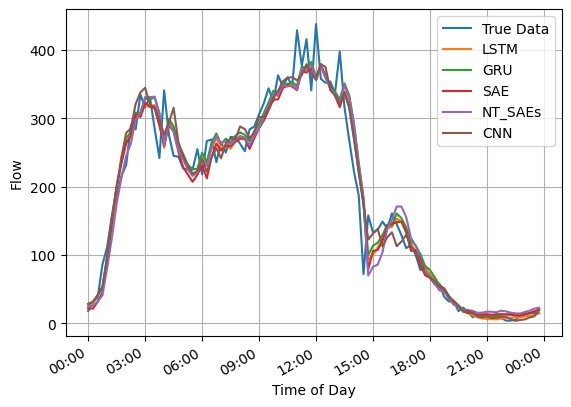

In [22]:
main()